In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir("drive/MyDrive/protein-embedding-02456-2020/notebooks")

In [4]:
! pip install Biopython

     |████████████████████████████████| 2.3MB 13.2MB/s 


# Notebook for embedding of balanced data
Downstream task: classifying beta-lactamase pfam family. 

In [5]:
# import general libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython import display

# import my functions
from training_functions import Dataset, my_collate
from data_functions import get_inputs_targets_from_sequences,\
 get_train_test, organize_fasta_header, IUPAC_VOCAB
from networks import Gru

In [6]:
# read in table from uniprot with info and sequences
name = "BL-cytoC_mix"
data=pd.read_csv("data_small/BL-cytoC_mix.tsv",sep='\t') #make sure you have updated the value above 
n_seq=data.shape[0]
data.head(n=2)

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Protein families,Taxonomic lineage (ALL),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Taxonomic lineage (CLASS),Taxonomic lineage (FAMILY),Taxonomic lineage (FORMA),Taxonomic lineage (GENUS),Taxonomic lineage (INFRACLASS),Taxonomic lineage (all),Beta strand,Helix,Turn,Mass,Cross-reference (Pfam),Sequence,Taxonomic lineage (PHYLUM),seq_len
0,P00004,CYC_HORSE,reviewed,Cytochrome c,CYCS CYC,Equus caballus (Horse),105,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, M...",apoptotic process [GO:0006915]; cytochrome c-h...,cytochrome complex [GO:0070069]; cytosol [GO:0...,cytochrome complex [GO:0070069]; cytosol [GO:0...,"electron transporter, transferring electrons f...",GO:0005758; GO:0005829; GO:0006122; GO:0006123...,Mammalia,Equidae (horses),NaN,Equus,NaN,"cellular organisms, Eukaryota, Opisthokonta, M...","STRAND 22..24; /evidence=""ECO:0000244|PDB:5IY...","HELIX 4..14; /evidence=""ECO:0000244|PDB:6K9J""...","TURN 15..18; /evidence=""ECO:0000244|PDB:6K9J""...","11,833",PF00034;,MGDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPG...,Chordata,105
1,P62897,CYC_MOUSE,reviewed,"Cytochrome c, somatic",Cycs,Mus musculus (Mouse),105,Cytochrome c family,"cellular organisms, Eukaryota, Opisthokonta, M...",activation of cysteine-type endopeptidase acti...,cytosol [GO:0005829]; mitochondrial intermembr...,cytosol [GO:0005829]; mitochondrial intermembr...,"electron transporter, transferring electrons f...",GO:0005634; GO:0005739; GO:0005758; GO:0005829...,Mammalia,Muridae,NaN,Mus,NaN,"cellular organisms, Eukaryota, Opisthokonta, M...",NaN,NaN,NaN,"11,605",PF00034;,MGDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAAG...,Chordata,105


In [7]:
# get indices for train/test split
train_idx, test_idx=get_train_test(list(range(n_seq)), list(range(n_seq)), train_frac=0.9)

# select train/test splits in table
train_table = data.iloc[train_idx[0]]
test_table = data.iloc[test_idx[0]]

# add <unk> and quote each letter #
# train 
train_seq=train_table["Sequence"].to_list()
train_seq=[list(seq) for seq in train_seq] 
_=[seq.append("<unk>") for seq in train_seq]


# test 
test_seq=test_table["Sequence"].to_list()
test_seq=[list(seq) for seq in test_seq]
_=[seq.append("<unk>") for seq in test_seq]

## get inputs and targets 
inputs_train, targets_train=get_inputs_targets_from_sequences(train_seq)
inputs_test, targets_test=get_inputs_targets_from_sequences(test_seq)


In [8]:
# convert AA to letters using dictionary
# targets =Y, inputs = X
# train 
targets_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_train]
inputs_train_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_train]
# test - for estimation of test error 
targets_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in targets_test]
inputs_test_num = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in inputs_test]
# test for investigaing embedding 
test_full_seq = [torch.tensor([IUPAC_VOCAB[i] for i in sequence]) for sequence in test_seq]

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
len(inputs_train_num)

13252

# Train the network

In [11]:
# prepare training and test data 
train_size = len(inputs_train)
test_size=len(inputs_test)
batch_size=32
train1 = Dataset(inputs_train_num[:train_size], targets_train_num[:train_size])
test1 = Dataset(inputs_test_num[:test_size], targets_test_num[:test_size])
# we define the dataloader for the training data 
trainloader = DataLoader(train1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

testloader = DataLoader(test1,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

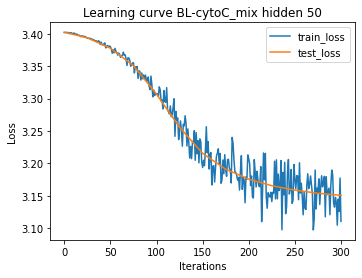

In [12]:
# set initialvalues 
vocab_size=len(IUPAC_VOCAB)
n_layers=10
hidden_size=50
max_iter = 300
eval_every = 25
log_every=50

# define the neural network
net = Gru(n_layers=n_layers, hidden_size=hidden_size, batch_size=batch_size, vocab=IUPAC_VOCAB)
net.to(device)

# define loss and optimizer 
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.00001)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001) # orig: momentum=0.9

# Track loss
stats = { 'test_loss': [], "train_loss":[], "test_iter":[], "train_iter":[]} 

i=0
while i<max_iter:
  for j,(inputs, targets, data) in enumerate(trainloader):

        if i % eval_every == 0:
          test_loss=0
          net.eval()
          # For each sentence in validation set
          for inputs_test, targets_test, data in testloader:
              inputs_test, targets_test = inputs_test.to(device), targets_test.to(device)
              outputs, h=net(inputs_test)

              # reshape the targets for use in loss function
              targets_test_f=[item for sublist in targets_test for item in sublist]
              targets_test_flat = torch.LongTensor(targets_test_f).to(device)  
        
              tag_pad_token=0
              mask = (targets_test_flat > tag_pad_token).float()
              nb_tokens = int(torch.sum(mask).item())
  
              # pick the values for the label and zero out the rest with the mask
              outputs = outputs[range(outputs.shape[0]), targets_test_flat] * mask

              # compute cross entropy loss which ignores all <PAD> tokens
              loss = -(torch.sum(outputs) / nb_tokens)
        
              # Update loss
              test_loss += loss.detach().cpu().numpy()

          stats["test_iter"].append(i)
          stats["test_loss"].append(test_loss/len(testloader))



        ###########
        # TRAIN
        ###########
        net.train()
        optimizer.zero_grad() 

        inputs, targets = inputs.to(device), targets.to(device)

        # predict using the model 
        outputs, h=net(inputs)
        
        # reshape the targets for use in loss function
        targets_f=[item for sublist in targets for item in sublist]
        targets_flat = torch.LongTensor(targets_f).to(device) 
        
        
        tag_pad_token=0
        mask = (targets_flat > tag_pad_token).float()
        nb_tokens = int(torch.sum(mask).item()) # data[0]
        # pick the values for the label and zero out the rest with the mask
        outputs = outputs[range(outputs.shape[0]), targets_flat] * mask
        loss = -(torch.sum(outputs) / nb_tokens)
        
        # Backward pass
        loss.backward() # get gradients 
        optimizer.step()
        
        # Update loss
        #epoch_training_loss += loss.detach().cpu().numpy()
        stats["train_loss"].append(loss.detach().cpu().numpy())
        stats["train_iter"].append(i)

        # Print loss every 10 iterations
        #if i % 10 == 0:
        #  print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')


        # Log i figure
        if i % log_every == 0:
          fig = plt.figure(figsize=(12,4))
          plt.subplot(1, 2, 1)
          plt.title("Learning curve {} hidden {}".format(name, hidden_size))
          plt.plot(stats["train_iter"], stats["train_loss"], label='train_loss')
          plt.plot(stats["test_iter"], stats["test_loss"], label='test_loss')
          plt.legend()
          plt.xlabel('Iterations')
          plt.ylabel('Loss')
          #fig.savefig("visualization/learning_curves/CE_{}".format(name))
          plt.show()
          display.clear_output(wait=True)

          #print(f'Iter {i}, training loss: {stats["train_loss"][-1]}, test loss: {stats["test_loss"][-1]}')
          #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))

        if i>max_iter:
          break
        i+=1




In [13]:
import pandas as pd
test_table_num=test_table.to_numpy()

# save the trained network for later 
PATH = '{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
print(PATH)

BL-cytoC_mix_b_32_train13252_iter300_hidden50.pth


In [ ]:
# uncomment to save network
#torch.save({
#    'state_dict':   net.state_dict(), 
#    'stats':        stats,
#    'args':         {"batch_size": batch_size, "n_layers":n_layers, "hidden_size":hidden_size, "vocab":IUPAC_VOCAB},
#    'test_full':    test_full_seq,
#    "test_table":    (test_table_num,test_table.columns),
#    "train_info":   {"optim":optimizer, "max_iter":max_iter},
#    "train_size":   train_size,
#    "train_idx":    train_idx,
#    "test_idx":     test_idx,
#},  "models/{}".format(PATH), _use_new_zipfile_serialization=False)

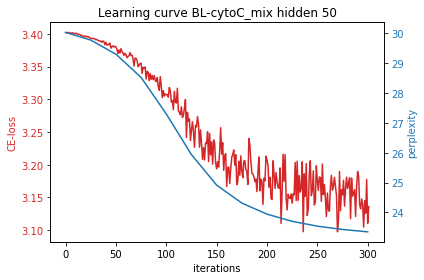

In [14]:
# x-axis 
iter = stats["train_iter"]

# Create some mock data
val_perplexity = np.exp(stats["test_loss"])

fig, ax1 = plt.subplots()
plt.title("Learning curve {} hidden {}".format(name, hidden_size))

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('CE-loss', color=color)
ax1.plot(iter, stats["train_loss"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(stats["test_iter"], val_perplexity, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.title("Learning curve {}".format("name")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.xlim(0,200)
#plt.show()
#plt.savefig("visualization/learning_curves/train_{}_hidden{}".format(name, hidden_size))

## Visualize embedding

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns 

In [16]:
pth=torch.load("models/{}_b_{}_train{}_iter{}_hidden{}.pth".format(name,batch_size, train_size, max_iter, hidden_size), map_location=torch.device('cpu'))


In [17]:
stats = pth["stats"]
test_info = pd.DataFrame(pth["test_table"][0], columns=pth["test_table"][1])
test = pth["test_full"]
n_layers = pth["args"]["n_layers"]

In [18]:
net=Gru(**pth["args"])
net.load_state_dict(pth["state_dict"])
net.eval()

Gru(
  (dropout): Dropout(p=0.5, inplace=False)
  (word_embedding): Embedding(30, 10, padding_idx=0)
  (linear1): Linear(in_features=10, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=40, bias=True)
  (gru): GRU(40, 50, num_layers=10, dropout=0.5)
  (l_out): Linear(in_features=50, out_features=30, bias=False)
)

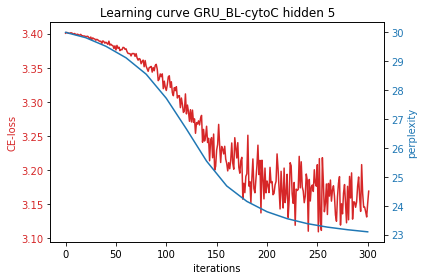

In [19]:
# x-axis 
name="GRU_BL-cytoC"
hidden_size=5
iter = stats["train_iter"]

# Create some mock data
val_perplexity = np.exp(stats["test_loss"])

fig, ax1 = plt.subplots()
plt.title("Learning curve {} hidden {}".format(name, hidden_size))

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('CE-loss', color=color)
ax1.plot(iter, stats["train_loss"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(stats["test_iter"], val_perplexity, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.title("Learning curve {}".format("name")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.xlim(0,200)
#plt.show()
plt.savefig("visualization/learning_curves/train_{}_hidden{}".format(name, hidden_size))

### Extract embeddings. 
We explore the different types of embeddings by first extracting the last hidden layer, then the average hidden layer and the max hidden layer.

In [20]:
emb_last=[]
emb_mean=[]
emb_max=[]
for i in range(0, len(test)):
    _,h=net(test[i])
    emb_last.append(h[n_layers-1].detach().numpy()[0])
    emb_mean.append(h.mean(dim=0).detach().numpy()[0])
    emb_max.append(h.max(dim=0)[0].detach().numpy()[0])


In [21]:
emb_last2D = TSNE(n_components=2).fit_transform(emb_last)
emb_mean2D = TSNE(n_components=2).fit_transform(emb_mean)
emb_max2D = TSNE(n_components=2).fit_transform(emb_max)

In [22]:
# save embedding to eg. asses via downstream task 
emb_save={"emb_last":emb_last, "emb_mean":emb_mean, "emb_max":emb_max, "emb_last2D":emb_last2D, "emb_mean2D":emb_mean2D, "emb_max2D":emb_max2D, "metadata":test_info}

PATH = 'embeddings/emb_{}_b_{}_train{}_iter{}_hidden{}.pth'.format(name, batch_size, train_size, max_iter,hidden_size)
PATH

'embeddings/emb_GRU_BL-cytoC_b_32_train13252_iter300_hidden5.pth'

In [ ]:
#torch.save(emb_save, PATH, _use_new_zipfile_serialization=False)

In [23]:
test_info.columns


Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Protein families', 'Taxonomic lineage (ALL)',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ontology (GO)',
       'Gene ontology (molecular function)', 'Gene ontology IDs',
       'Taxonomic lineage (CLASS)', 'Taxonomic lineage (FAMILY)',
       'Taxonomic lineage (FORMA)', 'Taxonomic lineage (GENUS)',
       'Taxonomic lineage (INFRACLASS)', 'Taxonomic lineage (all)',
       'Beta strand', 'Helix', 'Turn', 'Mass', 'Cross-reference (Pfam)',
       'Sequence', 'Taxonomic lineage (PHYLUM)', 'seq_len'],
      dtype='object')

In [24]:
test_info["Protein families"].value_counts()

Cytochrome c family                                                  444
Hcp beta-lactamase family                                            111
Cytochrome c family, PsbV subfamily                                  102
Class-A beta-lactamase family                                         98
Metallo-beta-lactamase superfamily, Glyoxalase II family              95
Peptidase S12 family, YfeW subfamily                                  95
Cytochrome c family, PetJ subfamily                                   94
Class-C beta-lactamase family                                         94
LysR transcriptional regulatory family                                87
Binding-protein-dependent transport system permease family            86
Class-D beta-lactamase family                                         84
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     83
Name: Protein families, dtype: int64

In [25]:
test_info["Taxonomic lineage (all) splitted"]=test_info["Taxonomic lineage (all)"].str.split(", ")

# get the different taxonomic levels for plotting
level3=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[2])
level2=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[1])
#level4=np.array(list(zip(*list(test_info["Taxonomic lineage (all) splitted"])))[3])



test_info["Protein families"].value_counts()

Cytochrome c family                                                  444
Hcp beta-lactamase family                                            111
Cytochrome c family, PsbV subfamily                                  102
Class-A beta-lactamase family                                         98
Metallo-beta-lactamase superfamily, Glyoxalase II family              95
Peptidase S12 family, YfeW subfamily                                  95
Cytochrome c family, PetJ subfamily                                   94
Class-C beta-lactamase family                                         94
LysR transcriptional regulatory family                                87
Binding-protein-dependent transport system permease family            86
Class-D beta-lactamase family                                         84
Metallo-beta-lactamase superfamily, Class-B beta-lactamase family     83
Name: Protein families, dtype: int64

Text(0, 0.5, 'y axis')

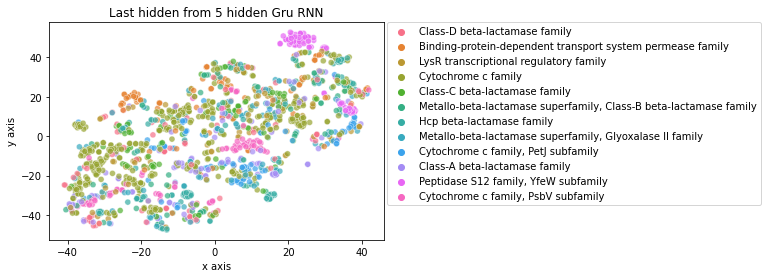

In [26]:
# visualize pfam 
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")
#plt.savefig("visualization/embedding/50hidden_gru_pfam_CytoC-BL.png", bbox_inches="tight")

Text(0, 0.5, 'y axis')

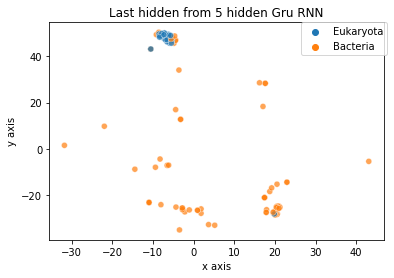

In [27]:

group=["Cytochrome c family, PsbV subfamily"]
idx=[i for i, e in enumerate(test_info["Protein families"]) if e in group]

sns.scatterplot(x=emb_max2D[idx,0], y=emb_max2D[idx,1], alpha=0.7, hue=level2[idx], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

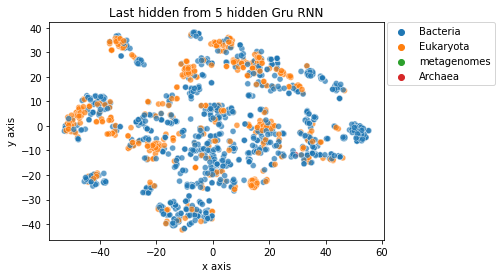

In [28]:
# visualize pfam 
sns.scatterplot(x=emb_mean2D[:,0], y=emb_mean2D[:,1], alpha=0.7, hue=level2, legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

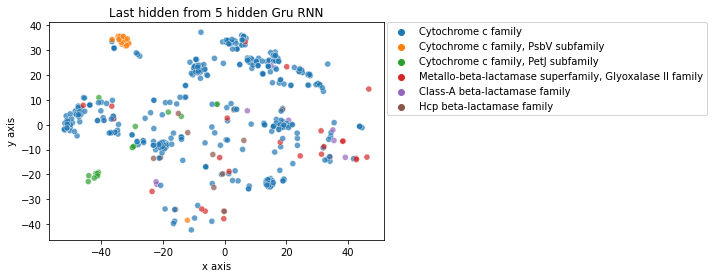

In [29]:
group=["Eukaryota"]
idx=[i for i, e in enumerate(level2) if e in group]

# visualize pfam 
sns.scatterplot(x=emb_mean2D[idx,0], y=emb_mean2D[idx,1], alpha=0.7, hue=test_info["Protein families"][idx], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

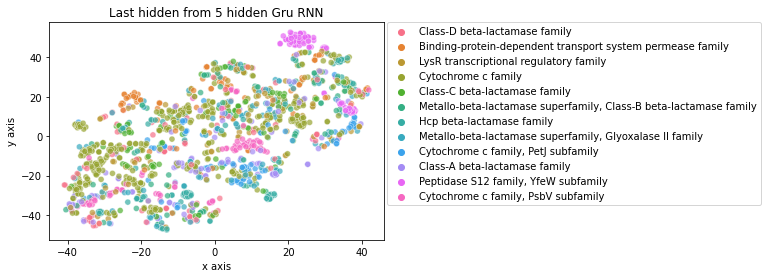

In [30]:
# visualize pfam 
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from {} hidden Gru RNN".format(hidden_size))
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

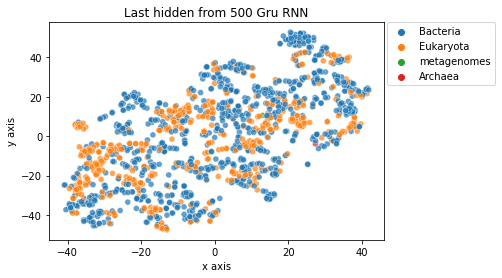

In [31]:
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=level2, legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

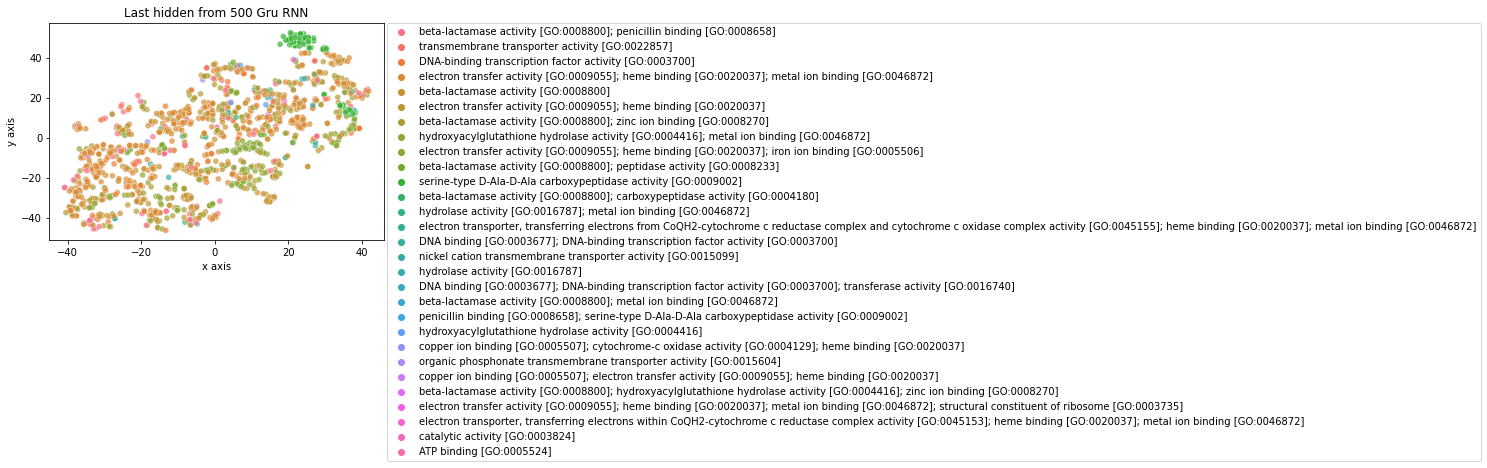

In [32]:

sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=test_info["Gene ontology (molecular function)"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

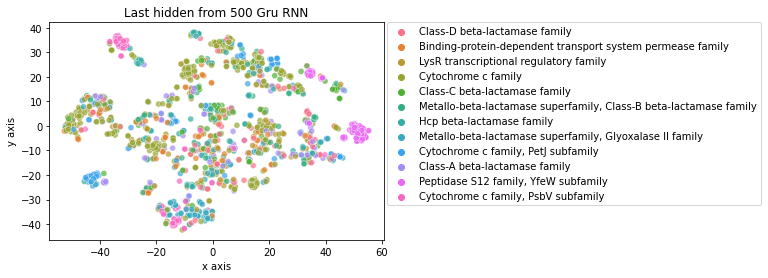

In [33]:
sns.scatterplot(x=emb_mean2D[:,0], y=emb_mean2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

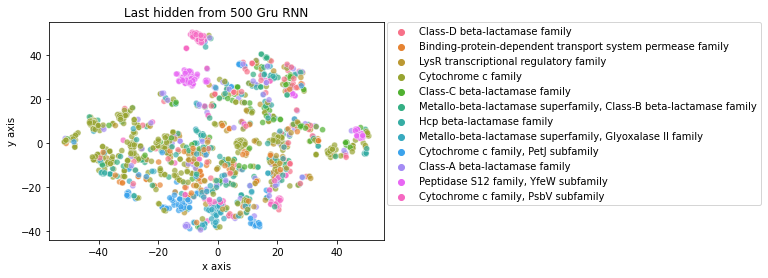

In [34]:
sns.scatterplot(x=emb_max2D[:,0], y=emb_max2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

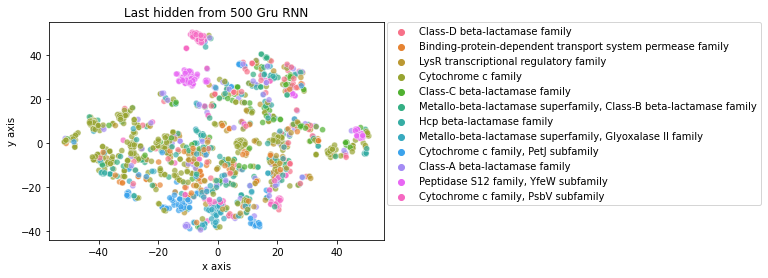

In [35]:
sns.scatterplot(x=emb_max2D[:,0], y=emb_max2D[:,1], alpha=0.7, hue=test_info["Protein families"], legend=True)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

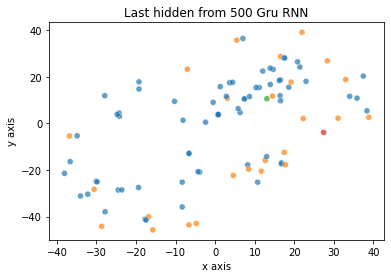

In [36]:
# if we want to only plot the sequences belonging to a specific family
group="Metallo-beta-lactamase superfamily, Glyoxalase II family"
idx=[i for i, e in enumerate(test_info["Protein families"]) if e == group]

sns.scatterplot(x=emb_last2D[idx,0], y=emb_last2D[idx,1], alpha=0.7, hue=level2[idx], legend=False)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")

Text(0, 0.5, 'y axis')

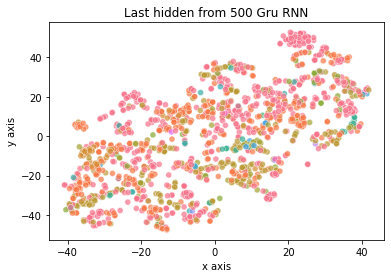

In [37]:
# visualize pfam 
sns.scatterplot(x=emb_last2D[:,0], y=emb_last2D[:,1], alpha=0.7, hue=level3, legend=False)
plt.title("Last hidden from 500 Gru RNN")
plt.xlabel("x axis")
plt.ylabel("y axis")